<a href="https://colab.research.google.com/github/Untick/NetOptik/blob/Polyakov-Alexander-branch/Polyakov%20Alexander/NASNetMobile_3_classes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Подготовка

In [7]:
import tensorflow as tf
from tensorflow.keras.applications import NASNetMobile
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint

In [8]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [9]:
DATA_DIR = '/content/drive/MyDrive/AI/datasets/arches/train/'
BATCH_SIZE = 32
IMG_SIZE = (224, 224)

In [14]:
datagen_train = ImageDataGenerator(rescale=1./255, validation_split=0.2)

datagen_train = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.1,      # использовать 10% данных для валидации
    rotation_range=20,         # случайный поворот на ±10 градусов
    width_shift_range=0.1,     # случайный сдвиг по ширине на ±10%
    height_shift_range=0.1,    # случайный сдвиг по высоте на ±10%
    zoom_range=0.2,            # случайное увеличение/уменьшение на ±20%
    horizontal_flip=True,      # случайное отражение по горизонтали
    brightness_range=[0.2, 0.5] # изменение яркости от 80% до 120%
)


train_generator = datagen_train.flow_from_directory(
    DATA_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training'
)

val_generator = datagen_train.flow_from_directory(
    DATA_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation'
)

Found 1080 images belonging to 3 classes.
Found 120 images belonging to 3 classes.


### Обучение лучшей модели

In [5]:
best_model_dir = '/content/drive/MyDrive/AI/datasets/arches/best_models/'


In [15]:
# Загрузка базовой модели VGG16
base_model = NASNetMobile(weights='imagenet', include_top=True)

# Продолжение модели с дополнительными слоями
x = base_model.output
x = Dense(1024, activation='relu')(x)
predictions = Dense(3, activation='softmax')(x)

# Собрать итоговую модель
model = Model(inputs=base_model.input, outputs=predictions)

# Отключение обучения базовых слоев
for layer in base_model.layers:
    layer.trainable = False

# Компиляция модели
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [16]:
checkpoint_callback = ModelCheckpoint(
    best_model_dir + 'best_model_NASNetMobile_val_accuracy.h5',
    monitor='val_accuracy',
    verbose=1,
    save_best_only=True,
    mode='max'
)

history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=50,
    callbacks=[checkpoint_callback]
)

Epoch 1/50
34/34 [==============================] - ETA: 0s - loss: 0.9712 - accuracy: 0.6972
Epoch 1: val_accuracy improved from -inf to 0.76667, saving model to /content/drive/MyDrive/AI/datasets/arches/best_models/best_model_NASNetMobile_val_accuracy.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


34/34 [==============================] - 207s 6s/step - loss: 0.9712 - accuracy: 0.6972 - val_loss: 0.7933 - val_accuracy: 0.7667
Epoch 2/50
34/34 [==============================] - ETA: 0s - loss: 0.6826 - accuracy: 0.7602
Epoch 2: val_accuracy did not improve from 0.76667
34/34 [==============================] - 35s 1s/step - loss: 0.6826 - accuracy: 0.7602 - val_loss: 0.6508 - val_accuracy: 0.7083
Epoch 3/50
34/34 [==============================] - ETA: 0s - loss: 0.5309 - accuracy: 0.7926
Epoch 3: val_accuracy improved from 0.76667 to 0.80000, saving model to /content/drive/MyDrive/AI/datasets/arches/best_models/best_model_NASNetMobile_val_accuracy.h5
34/34 [==============================] - 38s 1s/step - loss: 0.5309 - accuracy: 0.7926 - val_loss: 0.5634 - val_accuracy: 0.8000
Epoch 4/50
34/34 [==============================] - ETA: 0s - loss: 0.4930 - accuracy: 0.8093
Epoch 4: val_accuracy improved from 0.80000 to 0.82500, saving model to /content/drive/MyDrive/AI/datasets/arches

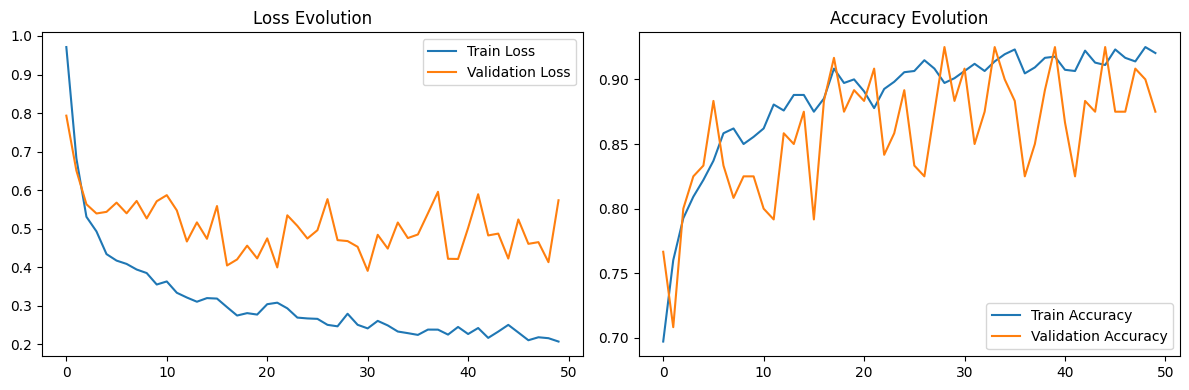

In [17]:
import matplotlib.pyplot as plt

# Визуализация потерь
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Loss Evolution')

# Визуализация точности
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Accuracy Evolution')

plt.tight_layout()
datagen = ImageDataGenerator(rescale=1./255)
plt.show()

In [18]:
from tensorflow.keras.models import load_model

best_model_dir = '/content/drive/MyDrive/AI/datasets/arches/best_models/'

model = load_model(best_model_dir + 'best_model_NASNetMobile_val_accuracy.h5')

Found 214 images belonging to 3 classes.
7/7 [==============================] - 35s 5s/step - loss: 0.6801 - accuracy: 0.6963
Test accuracy: 0.6962617039680481
7/7 [==============================] - 7s 251ms/step


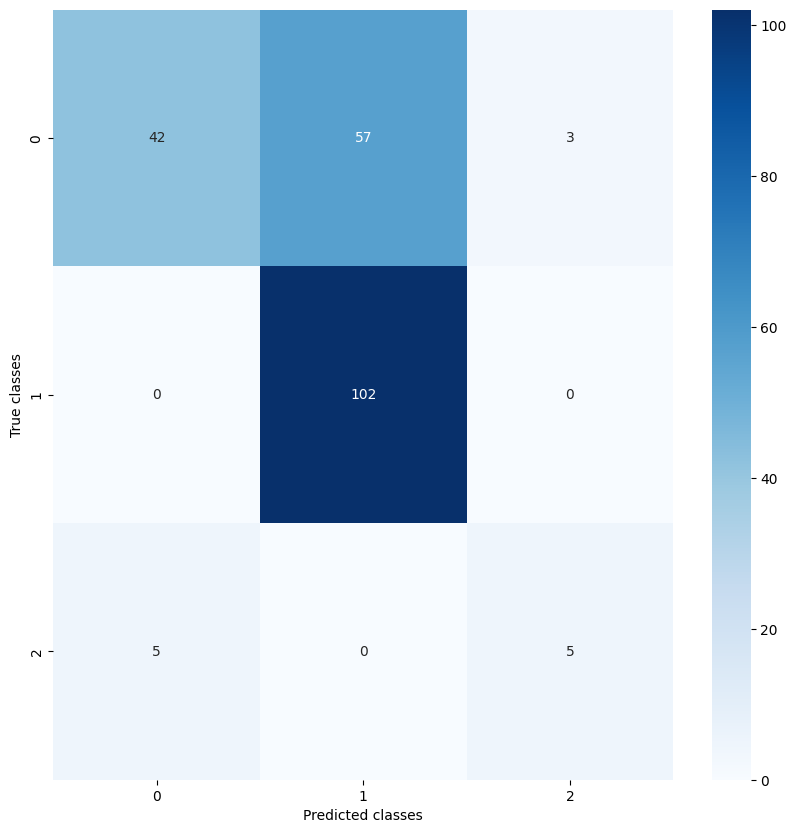

In [19]:
import numpy as np
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# исходные файлы
TEST_DIR = '/content/drive/MyDrive/AI/datasets/arches/test/'
datagen = ImageDataGenerator(rescale=1./255)

test_generator = datagen.flow_from_directory(
    TEST_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False # Это важно! Для сохранения исходного порядка
)

loss, accuracy = model.evaluate(test_generator)
print(f'Test accuracy: {accuracy}')

# Предсказания модели
predictions = model.predict(test_generator)
predicted_classes = np.argmax(predictions, axis=1)


true_classes = test_generator.classes

# Создание confusion matrix
cm = confusion_matrix(true_classes, predicted_classes)

# Визуализация
plt.figure(figsize=(10,10))
sns.heatmap(cm, annot=True, cmap="Blues", fmt='g')
plt.xlabel('Predicted classes')
plt.ylabel('True classes')
plt.show()